We will solve a Klein-Gordon equation:
$$\frac{\partial^2y}{\partial t^2}+\alpha\frac{\partial^2y}{\partial x^2}+\beta y+\gamma y^k=-x\cos(t)+x^2\cos^2(t),\quad x\in[-1,1],\quad t\in[0,10]$$
with initial conditions：
$$y(x,0)=x,\quad\frac{\partial y}{\partial t}(x,0)=0$$
and Dirichlet boundary conditions：
$$y(-1,t)=-\cos(t),\quad y(1,t)=\cos(t)$$
We also specify the following parameters for the equation:
$$\alpha=-1,\beta=0,\gamma=1,k=2.$$
The reference solution is：
$$y(x,t)=x\cos(t).$$

In [1]:
import sys
sys.path.append('H:/毕业论文/pykan')
sys.path.append('H:/毕业论文/efficient-kan/src')
from scipy.interpolate import griddata
from efficient_kan import KAN as EKAN
from kan import KAN, LBFGS
from kan import LBFGS
import torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

['d:\\conda\\envs\\pytorch\\python39.zip', 'd:\\conda\\envs\\pytorch\\DLLs', 'd:\\conda\\envs\\pytorch\\lib', 'd:\\conda\\envs\\pytorch', '', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python39\\site-packages', 'd:\\conda\\envs\\pytorch\\lib\\site-packages', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\win32', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\win32\\lib', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\Pythonwin', 'H:/毕业论文/pykan', 'H:/毕业论文/efficient-kan/src']


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Gradient-Cacl.  梯度批量计算
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


In [3]:
#geom 物理区域
geom = [-1,1]
num_points_x = 128  #网格的大小

#time domain number_points越大越好
TimeDomain = [0,10]
num_points_t = 50

#网格化
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

t = torch.linspace(TimeDomain[0],TimeDomain[1],
                   steps=num_points_t, device=device,
                   requires_grad=False)
X,T = torch.meshgrid(x, t, indexing='ij')  #生成网格

coordinates = torch.stack([X.flatten(), T.flatten()], dim = 1).to(device)
# print(coordinates,coordinates.shape)
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度
##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

In [4]:
#注意到我们其实需要的是一个 两个输入x和t 一个输出真解u 的KAN神经网络
layer = [2] + [2]*2 + [1]   #[input] + [nn]*hiden + [output] 

#oringinal KAN
# model = KAN(width=layer, grid=3, k=3, grid_eps=1,
#             noise_scale_base=0.25,device = device)

##efficient - KAN
model = EKAN(layer,grid_size=3,spline_order=3,scale_noise=0.1,grid_eps=1.0,base_activation=nn.Identity).to(device)

In [5]:
alpha = -1 
beta = 0
gamma = 1
k = 2

def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程：
    x = coords[:,0]
    t = coords[:,1] 
    u = model(coords)
    # print(x,x.shape)
    # print(t,t.shape)
    
    #coords[X,T]  [:, :, :]  前两个指的的真解u 后一个指的是对应的x和t x：0  t：1
    # u_x = grads[:,0, 0]
    u_tt = hessians[:,0,1]
    u_xx = hessians[:,0,0]  #d^2_u/dx^2


    #residuals of PDE：PDE的残差
    equation = u_tt + alpha * u_xx + beta * u + gamma * (u **k) + x * torch.cos(t) - (x**2) * (torch.cos(t) **2)
    pde_loss = torch.mean(equation ** 2)

    # BC and IC: 找到位于边界和初始上的点下标
    BC_mask_left = (coords[:, 0] == geom[0]) 
    BC_mask_righ = (coords[:, 0] == geom[1])
    IC_mask = (coords[:, 1] == TimeDomain[0])
    IC_points = coords[IC_mask][:,0].unsqueeze(1)  #t = 0时, x的坐标大小
    bc_points_left = coords[BC_mask_left][:,1].unsqueeze(1)
    bc_points_righ = coords[BC_mask_righ][:,1].unsqueeze(1)
    # print("BC_POINT",coords[BC_mask_righ],coords[BC_mask_righ].shape)
    print("IC_POINT",coords[IC_mask],coords[IC_mask].shape)

    ##BC:边界条件
    model_bc_left = model(coords[BC_mask_left])  
    model_bc_righ = model(coords[BC_mask_righ])
    bc_loss = torch.mean((model_bc_left + torch.cos(bc_points_left))**2) + torch.mean((model_bc_righ - torch.cos(bc_points_righ))**2)

    ##IC:初始条件
    model_ic_1st = model(coords[IC_mask])  
    loss_ic_1st = torch.mean((model_ic_1st - IC_points)**2)  #只能减去所对于的在边界或初始的点 而不能对所有的x都采取

    du_dt0 = batch_jacobian(model,coords[IC_mask],create_graph=True)[:,0,1]
    # print("du_dt0:",du_dt0,du_dt0.shape)
    loss_ic_2nd = torch.mean(du_dt0 **2)
    ic_loss = loss_ic_1st + loss_ic_2nd



    total_loss = pde_loss + bc_loss + ic_loss
    
    return total_loss

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

IC_POINT tensor([[-1.0000,  0.0000],
        [-0.9843,  0.0000],
        [-0.9685,  0.0000],
        [-0.9528,  0.0000],
        [-0.9370,  0.0000],
        [-0.9213,  0.0000],
        [-0.9055,  0.0000],
        [-0.8898,  0.0000],
        [-0.8740,  0.0000],
        [-0.8583,  0.0000],
        [-0.8425,  0.0000],
        [-0.8268,  0.0000],
        [-0.8110,  0.0000],
        [-0.7953,  0.0000],
        [-0.7795,  0.0000],
        [-0.7638,  0.0000],
        [-0.7480,  0.0000],
        [-0.7323,  0.0000],
        [-0.7165,  0.0000],
        [-0.7008,  0.0000],
        [-0.6850,  0.0000],
        [-0.6693,  0.0000],
        [-0.6535,  0.0000],
        [-0.6378,  0.0000],
        [-0.6220,  0.0000],
        [-0.6063,  0.0000],
        [-0.5906,  0.0000],
        [-0.5748,  0.0000],
        [-0.5591,  0.0000],
        [-0.5433,  0.0000],
        [-0.5276,  0.0000],
        [-0.5118,  0.0000],
        [-0.4961,  0.0000],
        [-0.4803,  0.0000],
        [-0.4646,  0.0000],
        [-0

Step: 0 | Loss: 1.518605: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

IC_POINT tensor([[-1.0000,  0.0000],
        [-0.9843,  0.0000],
        [-0.9685,  0.0000],
        [-0.9528,  0.0000],
        [-0.9370,  0.0000],
        [-0.9213,  0.0000],
        [-0.9055,  0.0000],
        [-0.8898,  0.0000],
        [-0.8740,  0.0000],
        [-0.8583,  0.0000],
        [-0.8425,  0.0000],
        [-0.8268,  0.0000],
        [-0.8110,  0.0000],
        [-0.7953,  0.0000],
        [-0.7795,  0.0000],
        [-0.7638,  0.0000],
        [-0.7480,  0.0000],
        [-0.7323,  0.0000],
        [-0.7165,  0.0000],
        [-0.7008,  0.0000],
        [-0.6850,  0.0000],
        [-0.6693,  0.0000],
        [-0.6535,  0.0000],
        [-0.6378,  0.0000],
        [-0.6220,  0.0000],
        [-0.6063,  0.0000],
        [-0.5906,  0.0000],
        [-0.5748,  0.0000],
        [-0.5591,  0.0000],
        [-0.5433,  0.0000],
        [-0.5276,  0.0000],
        [-0.5118,  0.0000],
        [-0.4961,  0.0000],
        [-0.4803,  0.0000],
        [-0.4646,  0.0000],
        [-0

Text(0.5, 1.0, 'Loss of KAN')

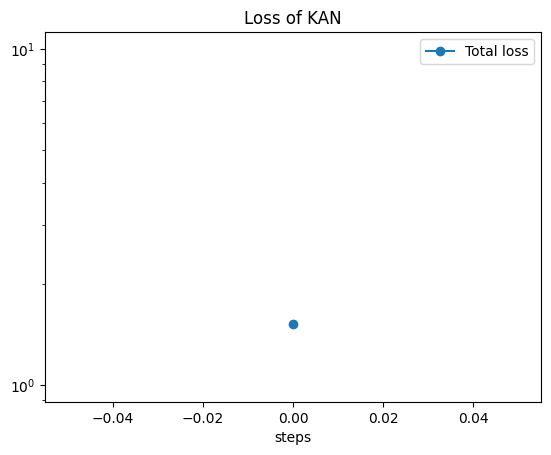

In [6]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    optimizer = LBFGS(model.parameters(), lr=1e-1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    
    steps = 1# 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

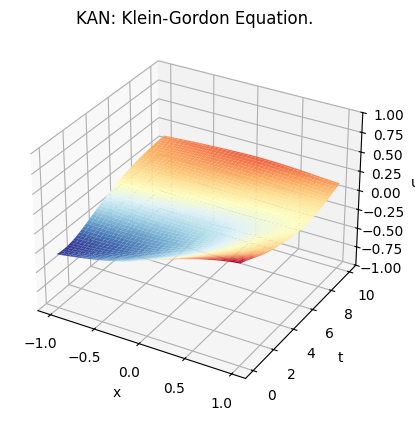

In [7]:
#画图
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt

t = np.linspace(0,10,100)
x = np.linspace(-1,1,256)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_x = torch.from_numpy(x).double().requires_grad_(True).to(device)
pt_t = torch.from_numpy(t).double().requires_grad_(True).to(device)
pt_u0 = model(torch.cat([pt_x,pt_t],1))
u = pt_u0.data.cpu().numpy()

pt_u0=u.reshape(100,256)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(ms_x, ms_t, pt_u0, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('KAN: Klein-Gordon Equation.') 
# plt.savefig('KAN.png')
plt.show(fig)